In [2]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM, GRU
from tensorflow import keras
import tensorflow as tf
from datetime import datetime

2022-11-17 15:21:55.291339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = read_csv("folder/subfolder/dataToModel.csv",
                 #  parse_dates={'dt' : ['Time']},
                  # infer_datetime_format=True, 
                   index_col= 0,
                   #na_values=['nan','?'],
                   sep=";")
#dataset.fillna(0, inplace=True)
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [4]:
dataset.head(4)

,rok,ms,dz,godz,fco2_MQ,fco2_HQ,fco2_raw,glwody,T50cm,T2m,...,Ku,Ld,Lu,ppp,v,vdir,Tgrunt,vwc,PARd,PARu
0,2013,1,1,0.5,0.15,0.0,0.15,5.2,1.2,1.5,...,0.9,249.3,322.9,998.5,3.4,210.5,0.6,0.785,0.0,0.0
1,2013,1,1,1.5,-0.60,0.0,-0.60,5.2,0.9,1.2,...,1.0,249.5,323.5,998.1,3.3,202.5,0.6,0.785,0.0,0.0
2,2013,1,1,2.5,0.57,0.0,0.57,5.4,0.7,1.0,...,1.0,249.7,324.0,997.6,3.3,201.6,0.6,0.785,0.0,0.0
3,2013,1,1,3.5,0.03,0.0,0.03,5.5,0.3,0.6,...,0.9,250.0,324.5,997.2,2.6,191.6,0.6,0.785,0.0,0.0


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40342 entries, 0 to 40341
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rok       40342 non-null  int64  
 1   ms        40342 non-null  int64  
 2   dz        40342 non-null  int64  
 3   godz      40342 non-null  float64
 4   fco2_MQ   23815 non-null  float64
 5   fco2_HQ   40342 non-null  float64
 6   fco2_raw  40342 non-null  float64
 7   glwody    40342 non-null  float64
 8   T50cm     40342 non-null  float64
 9   T2m       40342 non-null  float64
 10  Kd        40342 non-null  float64
 11  Ku        40342 non-null  float64
 12  Ld        40342 non-null  float64
 13  Lu        40342 non-null  float64
 14  ppp       40342 non-null  float64
 15  v         40342 non-null  float64
 16  vdir      40342 non-null  float64
 17  Tgrunt    40342 non-null  float64
 18  vwc       40342 non-null  float64
 19  PARd      40342 non-null  float64
 20  PARu      40342 non-null  fl

In [6]:
#dataset.drop(columns  = ['dz','godz','ms','fco2_MQ','rok'], inplace = True)
dataset.drop(columns  = ['dz','godz','ms','fco2_MQ','rok','glwody','T50cm','T2m','Kd','Ld','ppp','v','vdir','Tgrunt','vwc','PARd','PARu',"Ku",'Lu'], inplace = True)
#dataset.drop(columns  = [ 'fMOD_NN', 'fMOD_E0', 'fMODlut', 'fMODsrr','dz','godz','ms','fco2_MQ'], inplace = True)

In [9]:
dataset.head()

,fco2_HQ,fco2_raw
0,0.0,0.15
1,0.0,-0.60
2,0.0,0.57
3,0.0,0.03
4,0.0,0.03


In [10]:
dataset.drop(columns =[] , inplace = True)

In [11]:
#final dataset
dataset.head(2220)

,fco2_HQ,fco2_raw
0,0.0,0.15
1,0.0,-0.60
2,0.0,0.57
3,0.0,0.03
4,0.0,0.03
...,...,...
2215,1.0,-5.00
2216,1.0,-6.26
2217,1.0,-0.04
2218,0.0,-2.90


In [12]:
values = dataset.values
# ensure all data is float
values = values.astype('float64')

In [13]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)

In [14]:
scaled.head(2220)

,0,1
0,0.0,0.518109
1,0.0,0.517643
2,0.0,0.518370
3,0.0,0.518034
4,0.0,0.518034
...,...,...
2215,1.0,0.514905
2216,1.0,0.514121
2217,1.0,0.517991
2218,0.0,0.516212


In [15]:
def create_ts_data(dataset, lookback=1, predicted_col=0):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [16]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,0)
reframed_df.fillna(0, inplace=True)

#reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)','var6(t-1)','var7(t-1)','var8(t-1)','var9(t-1)','var10(t-1)','var11(t-1)','var12(t-1)','var13(t-1)','var14(t-1)','var15(t-1)','var16(t-1)','var17(t-1)']
#print(reframed_df.head(4))
reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)']

In [17]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.8)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [18]:
train_X.shape

(32273, 2)

In [19]:
train_y.shape

(32273,)

In [58]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

ValueError: cannot reshape array of size 64546 into shape (32273,5,1)

In [21]:
#model_gru = Sequential()
#model_gru.add(GRU(85, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
#model_gru.add(GRU(units=32, return_sequences=True))
#model_gru.add(GRU(units=32))
#model_gru.add(Dense(units=1))

#model_gru.compile(loss='mae', optimizer='adam')

In [23]:
model_gru = keras.models.Sequential([
    keras.layers.GRU(85, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])),
    keras.layers.GRU(units=36, return_sequences=True),
    keras.layers.GRU(units=36),
    keras.layers.Dense(units=1)
])
model_gru.compile(loss='mae', optimizer='adam')

2022-11-17 15:23:21.944033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 85)             22695     
                                                                 
 gru_1 (GRU)                 (None, 1, 36)             13284     
                                                                 
 gru_2 (GRU)                 (None, 36)                7992      
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 44,008
Trainable params: 44,008
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fit network
gru_history = model_gru.fit(train_X, train_y, epochs=10,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/10
505/505 [==============================] - 14s 13ms/step - loss: 0.2323 - val_loss: 0.2360
Epoch 2/10
505/505 [==============================] - 3s 7ms/step - loss: 0.2247 - val_loss: 0.2158
Epoch 3/10
505/505 [==============================] - 4s 8ms/step - loss: 0.2249 - val_loss: 0.2174
Epoch 4/10
505/505 [==============================] - 4s 9ms/step - loss: 0.2242 - val_loss: 0.2181
Epoch 5/10
505/505 [==============================] - 7s 15ms/step - loss: 0.2238 - val_loss: 0.2177
Epoch 6/10
505/505 [==============================] - 5s 9ms/step - loss: 0.2237 - val_loss: 0.2179
Epoch 7/10
505/505 [==============================] - 5s 10ms/step - loss: 0.2233 - val_loss: 0.2191
Epoch 8/10
505/505 [==============================] - 5s 10ms/step - loss: 0.2233 - val_loss: 0.2181
Epoch 9/10
505/505 [==============================] - 4s 8ms/step - loss: 0.2233 - val_loss: 0.2200
Epoch 10/10
505/505 [==============================] - 4s 8ms/step - loss: 0.2231 - val_loss: 0

In [26]:
pred_y =  model_gru.predict(test_X)

253/253 [==============================] - 2s 2ms/step


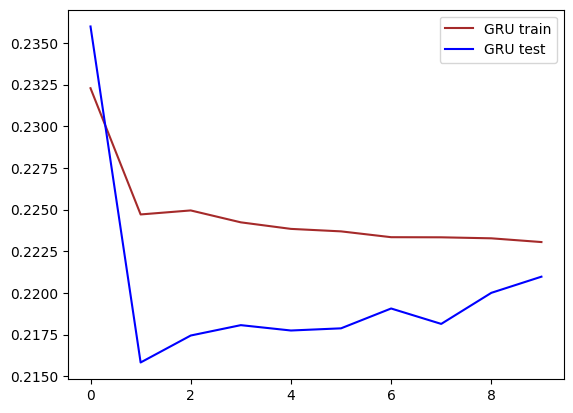

In [27]:
#dont run this cell if you are running this cell than add "validation_data=(test_X, test_y)" in model_gru.fit()
pyplot.plot(gru_history.history['loss'], label='GRU train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='GRU test', color='blue')
pyplot.legend()
pyplot.show()

In [35]:
test_y.reshape(8086,1)
#test_y.reshape(2627,1)

ValueError: cannot reshape array of size 8068 into shape (8086,1)

In [48]:
test_y.shape

(8068,)

In [49]:
test_y

array([1., 1., 0., ..., 0., 0., 0.])

In [37]:
pred_y

array([[1.0143223 ],
       [1.0143218 ],
       [1.0143222 ],
       ...,
       [0.00371458],
       [0.00371456],
       [0.00371461]], dtype=float32)

0.2176434758604941
-0.12900031209438345
0.46652274956372075
0.22097631467220705


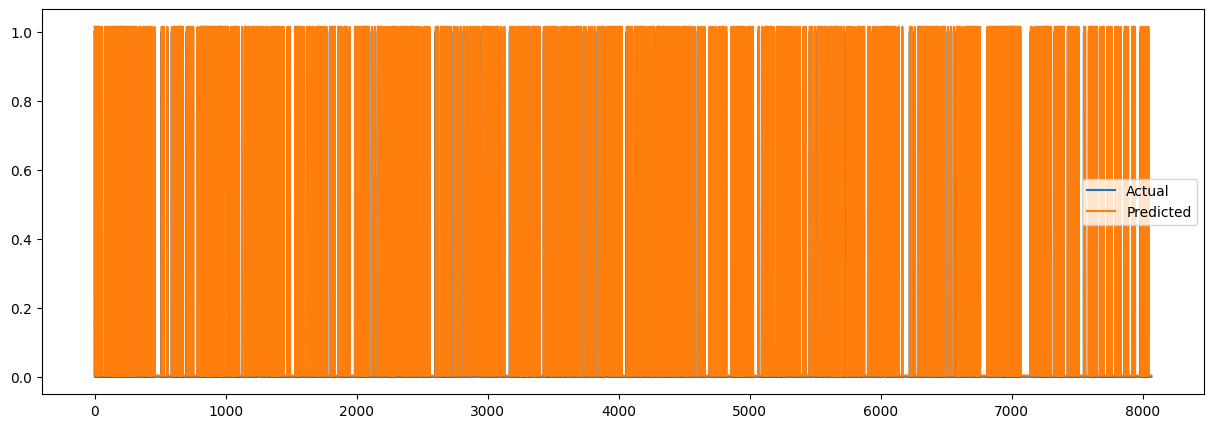

In [55]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

1261/1261 [==============================] - 4s 3ms/step


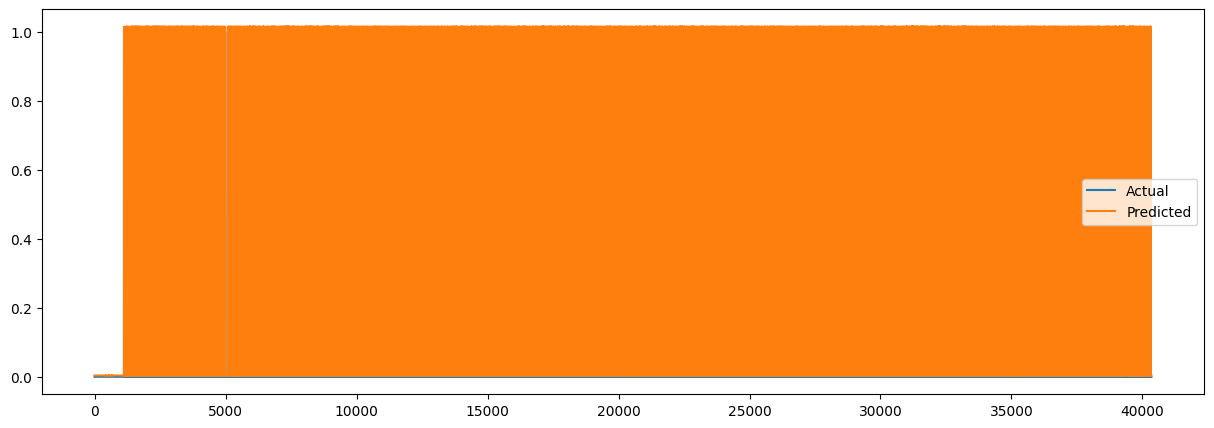

In [39]:
#visualization over full data
tra = np.concatenate([train_X,test_X])
tes = np.concatenate([train_y,test_y])
fp = model_gru.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

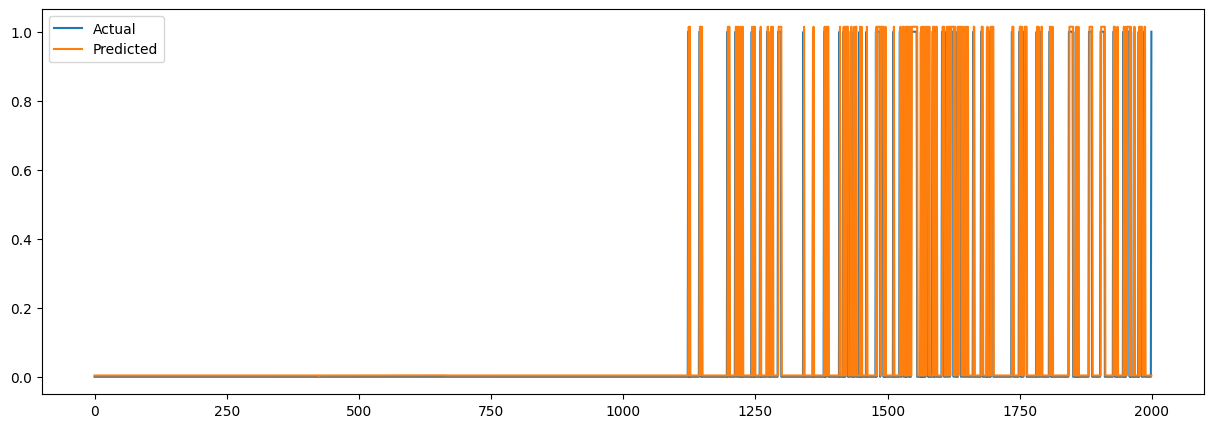

In [42]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()

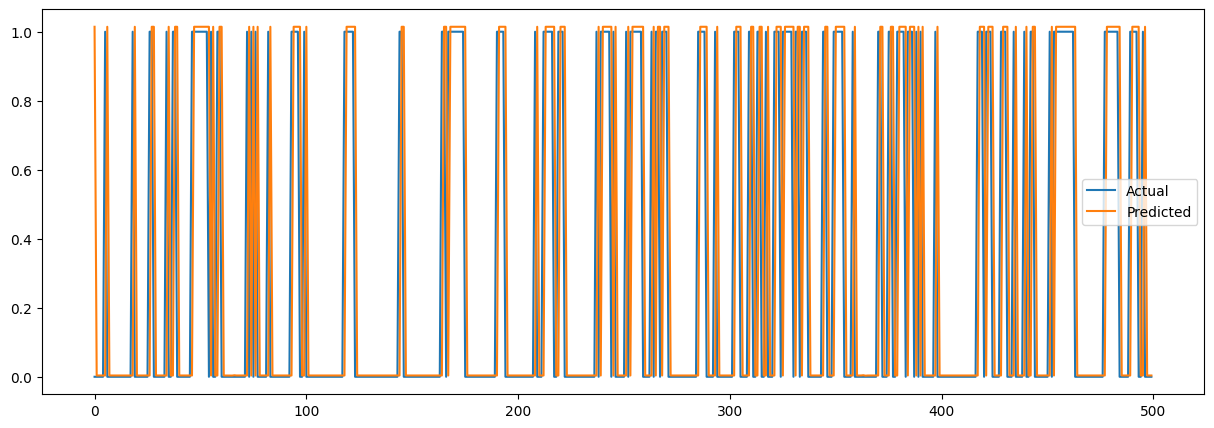

In [56]:
#over very small part of data
plt.plot(tes[2000:2500], label = 'Actual')
plt.plot(fp[2000:2500], label = 'Predicted')
plt.legend()
plt.show()

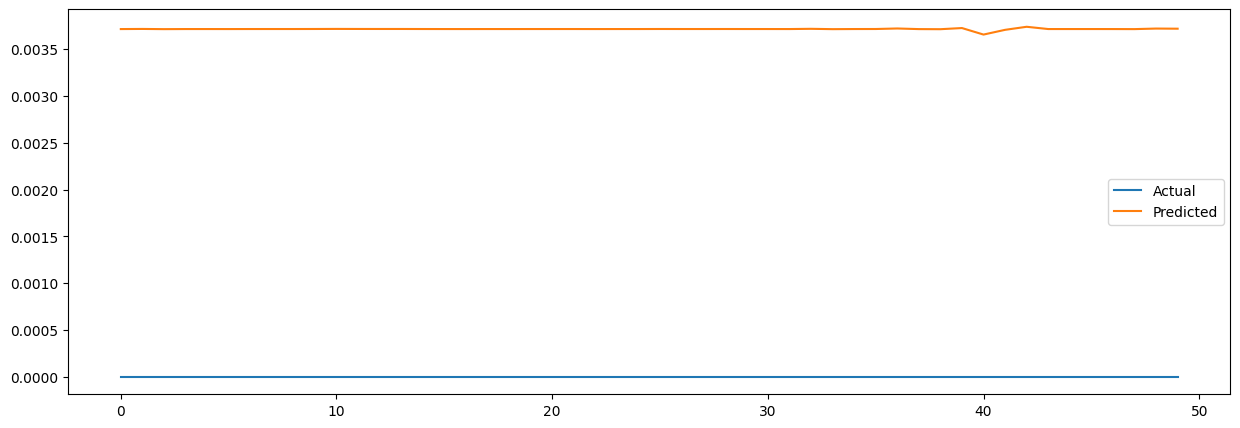

In [44]:
plt.plot(tes[:50], label = 'Actual')
plt.plot(fp[:50], label = 'Predicted')
plt.legend()
plt.show()

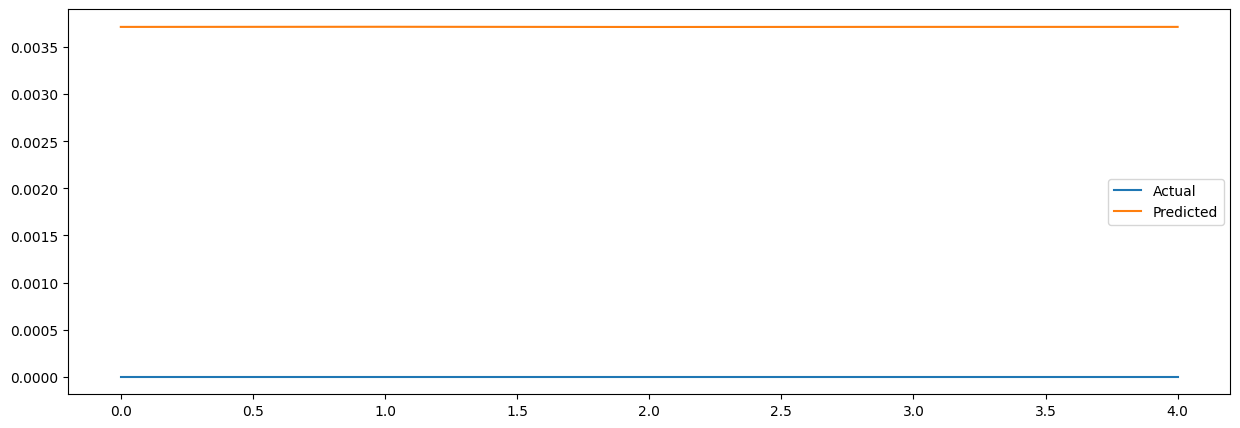

In [45]:
plt.plot(tes[:5], label = 'Actual')
plt.plot(fp[:5], label = 'Predicted')
plt.legend()
plt.show()

In [46]:
plt.plot(scaled[3], label = 'Actual')

KeyError: 3

In [ ]:
plt.plot(scaled[2], label = 'Actual')

In [ ]:
plt.plot(scaled[1], label = 'Actual')

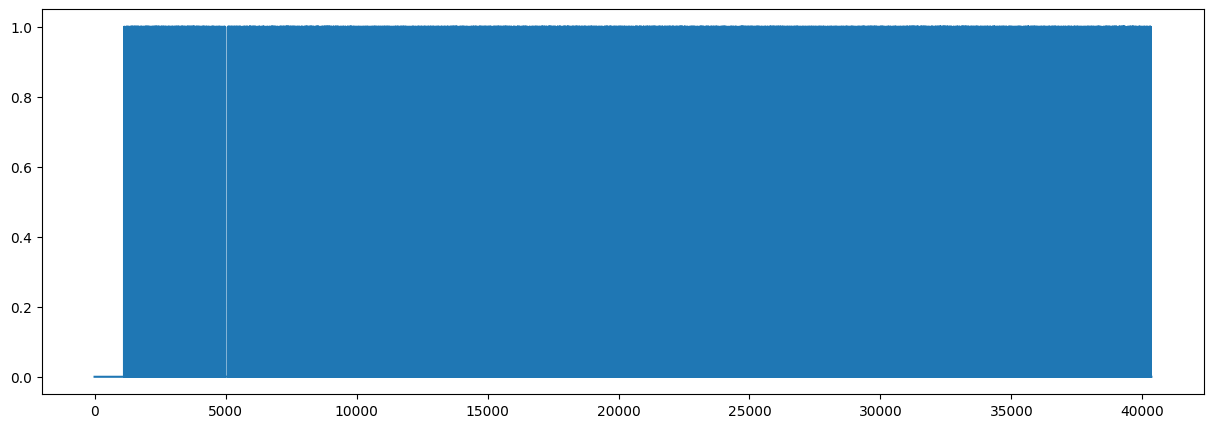

In [47]:
plt.plot(scaled[0], label = 'Actual')

In [629]:
n_steps = 5
window_length = n_steps + 1 # zmienna docelowa = sygnał wejściowy przesunięty o jeden znak do przodu
dataset['fco2_HQ']=dataset['fco2_HQ'].astype('int64')
dataset2 = tf.data.Dataset.from_tensor_slices(dataset)
dataset2 = dataset2.repeat().window(window_length, shift=1, drop_remainder=True)

In [630]:
dataset2 = dataset2.flat_map(lambda window: window.batch(window_length))

In [631]:
batch_size = 32
dataset2 = dataset2.shuffle(10000).batch(batch_size)
dataset2 = dataset2.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [632]:
dataset2 = dataset2.prefetch(1)

In [634]:
#dataset2 = dataset2.map(
 #   lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=1, dtype=tf.float32), Y_batch))

In [635]:
for X_batch, Y_batch in dataset2.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 5, 16) (32, 5, 16)


In [636]:
train_size = 40342 * 90 // 100

In [637]:
model = keras.models.Sequential([
    keras.layers.GRU(16, return_sequences=True, input_shape=[None,16],
                     # nie ma porzucania w stanowej sieci rekurencyjnej (https://github.com/ageron/handson-ml2/issues/32)
                     # dropout=0.2, recurrent_dropout=0.2,
                     ),
    keras.layers.GRU(16, return_sequences=True,
                     # dropout=0.2, recurrent_dropout=0.2
                    ),
    keras.layers.TimeDistributed(keras.layers.Dense(1,
                                                    activation="softmax"))
])
#model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model.compile(loss="mse", optimizer="adam")
history = model.fit(dataset2, steps_per_epoch=train_size // batch_size,epochs=10)
#history = model.fit(dataset, epochs=20,validation_data=(X_batch, Y_batch))

Epoch 1/10
1134/1134 [==============================] - 20s 12ms/step - loss: 100666.0078
Epoch 2/10
1134/1134 [==============================] - 11s 10ms/step - loss: 99750.7344
Epoch 3/10
1134/1134 [==============================] - 10s 9ms/step - loss: 99984.7734
Epoch 4/10
1134/1134 [==============================] - 10s 9ms/step - loss: 100119.0312
Epoch 5/10
1134/1134 [==============================] - 12s 10ms/step - loss: 100152.3281
Epoch 6/10
1134/1134 [==============================] - 10s 9ms/step - loss: 99964.3906
Epoch 7/10
1134/1134 [==============================] - 11s 9ms/step - loss: 100178.0234
Epoch 8/10
1134/1134 [==============================] - 10s 9ms/step - loss: 100147.1641
Epoch 9/10
1134/1134 [==============================] - 9s 8ms/step - loss: 100107.6719
Epoch 10/10
1134/1134 [==============================] - 9s 8ms/step - loss: 99750.6250


In [ ]:
X_new = 
Y_pred = model.predict(X_new)[:, -1,-1][..., np.newaxis]